In [1]:
import time
import re
import string
import random
import joblib

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, accuracy_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [2]:
ds = pd.read_csv(r'D:/VSCODE/Test-Project/product_reviews_dirty.csv', sep=",")

In [3]:
additional_stopwords = open('stopwords.txt').read().split()
sastrawi = StopWordRemoverFactory()
stopword_list = ' '.join(stopwords.words('indonesian') + sastrawi.get_stop_words())
stopword_list = word_tokenize(stopword_list)
stopword_list.remove('tidak') # remove 'tidak' from stopword since it may be related to negative sentiment
stopword_list.remove('tidak')

stemmer = StemmerFactory()
stemmer = stemmer.create_stemmer()

In [4]:
# removing emojis (source: https://gist.github.com/slowkow/remove-emoji.py)
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def clean_text(text):
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = text.replace('\n', ' ') # change enter to space
    text = text.replace(r'[^\w\d\s]', ' ')
    text = text.replace(r'\s+', ' ')
    text = text.replace(r'^\s+|\s+?$', ' ')
    text = remove_emoji(text)
    
    # "barang" is removed, since it will always be included in both sentiment
    text = text.replace(r'barang', '')
    text = text.replace(r'nya', '')
    text = text.translate(str.maketrans(' ', ' ', string.punctuation)) #remove punctuation
    text = text.strip(' ') # remove space char from both left and right text
    return text

def lower_text(text):
    return text.lower()

def tokenize_text(text):
    return word_tokenize(text)
    
def filter_text(text):
    filtered = list()
    for txt in text:
        if txt not in stopword_list:
            filtered.append(txt)
    text = filtered
    return text

def stem_text(text):
    text = [stemmer.stem(word) for word in text]
    return text

def to_sentence(word_list):
    sentence = ' '.join(word for word in word_list)
    return sentence

def preprocess_text(text):
    text = lower_text(text)
    cleaned_ = clean_text(text)
    tokenized_ = tokenize_text(cleaned_)
    filtered_ = filter_text(tokenized_)
    stemmed_ = stem_text(filtered_)
    sentence_ = to_sentence(stemmed_)
    return cleaned_, stemmed_, sentence_
    
def undersample(a, b):
    rand_state = 23
    if len(a) < len(b):
        b = b.sample(n=min(len(a),len(b)), random_state=rand_state)
    else:
        a = a.sample(n=min(len(a),len(b)), random_state=rand_state)
    return a, b

In [ ]:
df_review = ds[['text', 'rating']]
c_, s_, st_ = list(), list(), list()

for txt in tqdm(df_review.text):
    c_.append(preprocess_text(txt)[0])
    s_.append(preprocess_text(txt)[1])
    st_.append(preprocess_text(txt)[2])

In [ ]:
df_review['text_clean'] = c_
df_review['text_preprocessed'] = s_
df_review['sentence_preprocessed'] = st_
df_review.head()

In [5]:
dataset_filename = "cleaned_dataset.pkl"

# saving preprocessed dataset to file
# df_review.to_pickle(dataset_filename)

# load saved file
df_review = pd.read_pickle(dataset_filename)

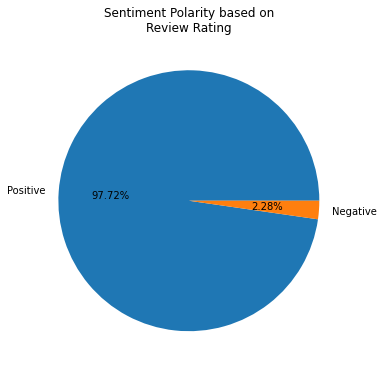

In [6]:
rating_sentiment = list()
for rating in df_review.rating:
    if rating >= 3:
        rating_sentiment.append(1)
    else:
        rating_sentiment.append(0)
df_review['sentiment'] = rating_sentiment

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Sentiment Polarity based on\nReview Rating')
df_review.sentiment.value_counts().plot(kind='pie',
                                        autopct='%1.2f%%',
                                        ax=ax,
                                        label='',
                                        labels=['Positive','Negative'])
plt.show()

Sentiment labeling was done based on rating score given by the reviewers. Rating score >= 3 was considered positive, otherwise was negative. As shown by figure above, the sentiments was extremely imbalanced. So undersampling was performed to handle it.

### Visualize Word Cloud

100%|█████████████████████████████████████████| 40607/40607 [00:00<00:00, 233356.58it/s]


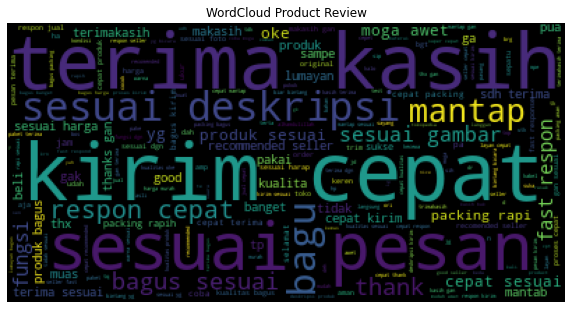

In [7]:
word_list = ''
for rev in tqdm(df_review['text_preprocessed']):
    for word in rev:
        word_list += ' '+(word)

wordcloud = WordCloud(background_color='black',
                     min_font_size=3).generate(word_list)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('WordCloud Product Review')
ax.imshow((wordcloud))
ax.axis('off')
plt.show()

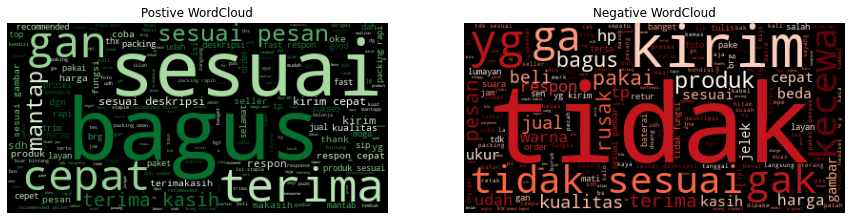

In [8]:
# summarizing positive and negative words

pos_words_text = df_review[df_review.sentiment == 1].text_preprocessed
neg_words_text = df_review[df_review.sentiment == 0].text_preprocessed

pos_words = ''
neg_words = ''

for txtpos, txtneg in zip(pos_words_text, neg_words_text):
    for wordpos, wordneg in zip(txtpos, txtneg):
        pos_words += ' '+(wordpos)
        neg_words += ' '+(wordneg)

pos_wCloud = WordCloud(background_color='black',
                       min_font_size=3, colormap='Greens',
                       stopwords=stopword_list).generate(pos_words)
neg_wCloud = WordCloud(background_color='black',
                       min_font_size=3, colormap='Reds',
                       stopwords=stopword_list).generate(neg_words)

fig, ax = plt.subplots(1,2, figsize=(15,9))
ax[0].set_title('Postive WordCloud')
ax[0].imshow(pos_wCloud)
ax[0].axis('off')

ax[1].set_title('Negative WordCloud')
ax[1].imshow(neg_wCloud)
ax[1].axis('off')
plt.show()


In [38]:
df_review.sentiment.value_counts()

1    39682
0      925
Name: sentiment, dtype: int64

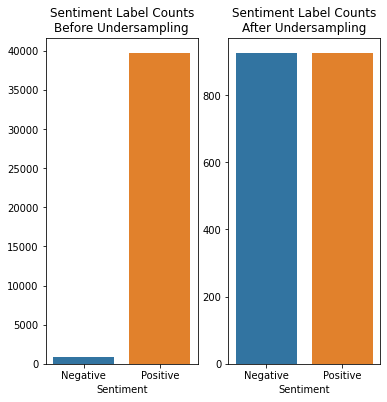

In [58]:
# Handling extremly imbalanced data with random undersampling.

pos_ = df_review[df_review.sentiment == 1][['sentence_preprocessed', 'sentiment']]
neg_ = df_review[df_review.sentiment == 0][['sentence_preprocessed', 'sentiment']]

pos_sample, neg_sample = undersample(pos_, neg_)

fig, ax = plt.subplots(1,2, figsize=(6,6))
ax[0].set_title('Sentiment Label Counts\nBefore Undersampling')
sns.barplot(x=df_review.sentiment.value_counts().index,
            y=df_review.sentiment.value_counts().values,
            ax=ax[0])
ax[0].set_xticklabels(['Negative', 'Positive'])
ax[0].set_xlabel('Sentiment')

ax[1].set_title('Sentiment Label Counts\nAfter Undersampling')
sns.barplot(x=pd.concat([pos_sample, neg_sample], axis=0).sentiment.value_counts().index,
            y=pd.concat([pos_sample, neg_sample], axis=0).sentiment.value_counts().values,
            ax=ax[1])
ax[1].set_xticklabels(['Negative', 'Positive'])
ax[1].set_xlabel('Sentiment')
plt.show()

### Designing pipeline and train model

In [10]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
pipe = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=stopword_list,
                                   tokenizer=token.tokenize,
                                   ngram_range=(1,2),
                                   lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', XGBClassifier(eval_metric='logloss',
                          use_label_encoder=False))
])

In [11]:
X = pd.concat([pos_sample, neg_sample], axis=0)['sentence_preprocessed']
y = pd.concat([pos_sample, neg_sample], axis=0)['sentiment']

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1480,), (1480,), (370,), (370,))

In [13]:
cv = StratifiedKFold(10, shuffle=True,random_state=23)

params = [{
    'vectorizer__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],
    'clf__n_estimators': np.linspace(1, 100, 50).astype(int),
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__max_depth': [3, 4, 5]
}]

scores = {
    'acc': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='micro')
}

gs = RandomizedSearchCV(pipe,
                        param_distributions=params,
                        n_jobs=-1,
                        scoring=scores,
                        refit='acc',
                        cv=cv,
                        n_iter=1000,
                        verbose=10)

result = gs.fit(x_train, y_train)

mean_acc = result.cv_results_['mean_test_acc']
mean_recall = result.cv_results_['mean_test_recall']
params = result.cv_results_['params']

gs_df = pd.DataFrame(zip(params, mean_acc, mean_recall),
                     columns=['Parameter', 'Mean Accuracy', 'Mean recall'])
gs_df.head()

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


D:\PythonThings\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,Parameter,Mean Accuracy,Mean recall
0,"{'vectorizer__max_df': 0.3, 'clf__subsample': ...",0.813514,0.813514
1,"{'vectorizer__max_df': 0.7, 'clf__subsample': ...",0.729730,0.729730
2,"{'vectorizer__max_df': 0.7, 'clf__subsample': ...",0.700000,0.700000
3,"{'vectorizer__max_df': 0.5, 'clf__subsample': ...",0.779054,0.779054
4,"{'vectorizer__max_df': 0.4, 'clf__subsample': ...",0.770946,0.770946


In [14]:
model_filename = 'review-sentiment_rs-xgboost.pkl'

# save best estimator to disk
joblib.dump(gs.best_estimator_, model_filename)

# load saved model from disk
# gs = joblib.load(model_filename)

['review-sentiment_rs-xgboost.pkl']

### Evaluation

In [15]:
y_pred = gs.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77       185
           1       0.74      0.90      0.81       185

    accuracy                           0.79       370
   macro avg       0.81      0.79      0.79       370
weighted avg       0.81      0.79      0.79       370



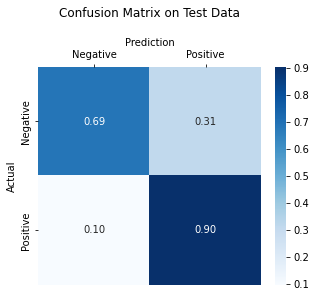

In [21]:
cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.show()

Confusion matrix shows a good results for predicting positive sentiments but lower recall on negative sentiments. There are rooms for improvement on preprocessing steps to get better results.

In [17]:
# Run this cell to test arbitrary input text.

dicts = {
    0: 'Negative',
    1: 'Positive'
}

input_text = input('> ').lower()
_, _, preprocessed_text = preprocess_text(input_text)
test_predict = gs.predict([preprocessed_text])
time.sleep(0.3)
print(f'\n"{dicts[test_predict[0]]}"')

> tidak sesuai deskripsi

"Negative"
